In [1]:
%matplotlib inline

In [2]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from ipywidgets import *
from IPython.display import *
import copy

In [3]:
def set_seed(seed=None):
    """Making the seed (for random values) variable if None"""

    if seed is None:
        import time
        seed = int((time.time()*10**6) % 4294967295)
        print(seed)
    try:
        np.random.seed(seed)
        print("Seed used for random values:", seed)
    except:
        print("!!! WARNING !!!: Seed was not set correctly.")
    return seed

In [4]:
class Network(object):

    def __init__(self, trainLen=2000, testLen=2000, initLen=100) :
        self.initLen = initLen #temps d'initialisation
        self.trainLen = trainLen #temps d'entrainement
        self.testLen = testLen #temps de test
        self.data = np.loadtxt("MackeyGlass_t17.txt")
        self.inSize = self.outSize = 1 #Dimension de l'entrée et de la sortie
        self.resSize = 300 #Taille du réservoir (prédiction)
        #self.resSize = 1000 #Taille du réservoir (géneration)
        self.a = 0.3 #Taux de fuite alpha 
        self.spectral_radius = 1.25 #Rayon spectral
        self.input_scaling = 1. #Echelle de l'input
        self.reg =  1e-8 #None #Coefficient de régularisation - si None,
        #on utilisera le pseudo-inverse plutôt que la régression de crête

        self.mode = 'prediction'
        #self.mode = 'generative'

        #Modification de la première valeur pseudo-aléatoire : les performances du réservoir
        #devraient être dans la moyenne après 20 instances aléatoires (pour les mêmes paramètres)
        seed = None #42

        set_seed(seed)
        
nw = Network()

2003486712
Seed used for random values: 2003486712


In [5]:
def initialisation(nw) :

    #Poids
    nw.Win = (np.random.rand(nw.resSize,1+nw.inSize)-0.5) * nw.input_scaling
    nw.W = np.random.rand(nw.resSize,nw.resSize)-0.5 
    
    #Matrices
    #Matrice des états collectés (1,u,x) au cours du temps
    nw.X = np.zeros((1+nw.inSize+nw.resSize,nw.trainLen-nw.initLen))
    #Matrice de sortie cible
    nw.Ytarget = nw.data[None,nw.initLen+1:nw.trainLen+1]

    #Vecteur des états du réservoir
    nw.x = np.zeros((nw.resSize,1))  
    
    return(nw)

In [6]:
def calcul_rayon_spectral(nw):
    print('Calcul du rayon spectral',end=" ")
    rhoW = max(abs(linalg.eig(nw.W)[0]))
    print('effectué.')
    nw.W *= nw.spectral_radius / rhoW
    
    return(nw)

In [7]:
def apprentissage(nw) :
    for t in range(nw.trainLen):
        #Données en entrée, issues de data
        nw.u = nw.data[t]
        nw.x = (1-nw.a)*nw.x + nw.a*np.tanh( np.dot(nw.Win, np.vstack((1,nw.u)) ) + np.dot( nw.W, nw.x ) )
        #Au bout d'un certain temps, on modifie X
        if t >= nw.initLen:
            nw.X[:,t-nw.initLen] = np.vstack((1,nw.u,nw.x))[:,0]
            
    return(nw)

In [8]:
def entrainement_sortie(nw) :
    nw.X_T = nw.X.T
    if nw.reg is not None:
        # Régression de crête (régression linéaire avec régularisation)
        nw.Wout = np.dot(np.dot(nw.Ytarget,nw.X_T), linalg.inv(np.dot(nw.X,nw.X_T) + \
            nw.reg*np.eye(1+nw.inSize+nw.resSize) ) )
    else:
        # Utilisation du pseudo-inverse
        nw.Wout = np.dot(nw.Ytarget, linalg.pinv(nw.X) )
    return(nw)

In [9]:
def test(nw) :
    nw.Y = np.zeros((nw.outSize,nw.testLen))
    nw.u = nw.data[nw.trainLen]
    for t in range(nw.testLen):
        nw.x = (1-nw.a)*nw.x + nw.a*np.tanh( np.dot(nw.Win, np.vstack((1,nw.u)) ) + np.dot(nw.W,nw.x ) )
        nw.y = np.dot(nw.Wout, np.vstack((1,nw.u,nw.x)) )
        nw.Y[:,t] = nw.y
        if nw.mode == 'generative':
            #Mode génératif:
            nw.u = nw.y
        elif nw.mode == 'prediction':
            #Mode prédictif:
            nw.u = nw.data[nw.trainLen+t+1] 
        else:
            raise(Exception, "ERREUR: le 'mode' n'a pas été correctement déclaré.")

    return(nw)

In [10]:
def calcul_erreur(nw) :
    # Calcul du MSE pour les premières errorLen itérations
    errorLen = 500
    mse = sum( np.square( nw.data[nw.trainLen+1:nw.trainLen+errorLen+1] - nw.Y[0,0:errorLen] ) ) / errorLen
    print('MSE = ' + str( mse ))
    
    return(nw)

In [11]:
def calcul_reseau(nw) :
    nw = initialisation(nw)
    nw = calcul_rayon_spectral(nw)
    nw = apprentissage(nw)
    nw = entrainement_sortie(nw)
    nw = test(nw) 
    nw = calcul_erreur(nw)
    return(nw)

In [12]:
select_mode = ToggleButtons(description='Mode:',
    options=['prediction', 'generative'])
var1 = FloatSlider(value=300, min=0, max=1000, step=1, description='resSize')
var2 = FloatSlider(value=100, min=0, max=2000, step=1, description='initLen')
var3 = FloatSlider(value=2000, min=0, max=5000, step=1, description='trainLen')
var4 = FloatSlider(value=2000, min=0, max=5000, step=1, description='testLen')
var5 = FloatSlider(value=1.25, min=0, max=10, step=0.05, description='spectral radius')
var6 = FloatSlider(value=0.3, min=0, max=1, step=0.01, description='leak rate')
valid = Button(description='Valider')

def record_values(_) :
    clear_output()
    nw.mode=select_mode.value
    nw.resSize=int(var1.value)
    nw.initLen=int(var2.value)
    nw.trainLen=int(var3.value)
    nw.testLen=int(var4.value)
    nw.spectral_radius=float(var5.value)
    nw.a=float(var6.value)
    print("InitLen:", nw.initLen, "TrainLen:", nw.trainLen, "TestLen:", nw.testLen) 
    print("ResSize:", nw.resSize, "Spectral Radius:", nw.spectral_radius, "Leak Rate:", nw.a)
    calcul_reseau(nw)
    return(nw)

display(select_mode)
display(var1)
display(var2)
display(var3)
display(var4)
display(var5)
display(var6)
display(valid)

valid.on_click(record_values)

ToggleButtons(description='Mode:', options=('prediction', 'generative'), value='prediction')

FloatSlider(value=300.0, description='resSize', max=1000.0, step=1.0)

FloatSlider(value=100.0, description='initLen', max=2000.0, step=1.0)

FloatSlider(value=2000.0, description='trainLen', max=5000.0, step=1.0)

FloatSlider(value=2000.0, description='testLen', max=5000.0, step=1.0)

FloatSlider(value=1.25, description='spectral radius', max=10.0, step=0.05)

FloatSlider(value=0.3, description='leak rate', max=1.0, step=0.01)

Button(description='Valider', style=ButtonStyle())

In [13]:
def get_corpus():
    l_input = ['by', 'from', 'he', 'him', 'it', 'on', 'that', 'the', 'then', 'to', 'was', '.', 'N', 'V']
    l_data = [['N', 'V', 'the', 'N', '.', 'then', 'he', 'V', 'it', '.'], #0
              ['the', 'N', 'was', 'V', 'by', 'N', '.', 'then', 'he', 'V', 'it', '.'], #1
              ['N', 'V', 'the', 'N', 'on', 'the', 'N', '.', 'then', 'he', 'V', 'it', '.'], #2
              ['the', 'N', 'was', 'V', 'on', 'the', 'N', 'by', 'N', '.', 'then', 'he', 'V', 'it', '.'], #3
              ['it', 'was', 'on', 'the', 'N', 'that', 'N', 'V', 'the', 'N', '.', 'then', 'he', 'V', 'it', '.'], #4
              ['N', 'V', 'the', 'N', '.'], #5
              ['the', 'N', 'was', 'V', 'by', 'N', '.'], #6
              ['N', 'V', 'the', 'N', 'on', 'the', 'N', '.'], #7
              ['the', 'N', 'was', 'V', 'on', 'the', 'N', 'by', 'N', '.'], #8
              ['it', 'was', 'on', 'the', 'N', 'that', 'N', 'V', 'the', 'N', '.'], #9
              ['N', 'V', 'the', 'N', '.', 'then', 'it', 'V', 'him', '.'], #10
              ['the', 'N', 'was', 'V', 'by', 'N', '.', 'then', 'it', 'V', 'him', '.'], #11
              ['N', 'V', 'the', 'N', 'on', 'the', 'N', '.', 'then', 'it', 'V', 'him', '.'], #12
              ['the', 'N', 'was', 'V', 'on', 'the', 'N', 'by', 'N', '.', 'then', 'it', 'V', 'him', '.'], #13
              ['it', 'was', 'on', 'the', 'N', 'that', 'N', 'V', 'the', 'N', '.', 'then', 'it', 'V', 'him', '.'], #14
              ['the', 'N', 'V', 'the', 'N', '.'], #15
              ['the', 'N', 'was', 'V', 'by', 'the', 'N', '.'], #16
              ['the', 'N', 'V', 'the', 'N', 'to', 'the', 'N', '.'], #17
              ['the', 'N', 'was', 'V', 'to', 'the', 'N', 'by', 'the', 'N', '.'], #18
              ['the', 'N', 'V', 'the', 'N', 'the', 'N', '.'], #19
              ['the', 'N', 'that', 'V', 'the', 'N', 'V', 'the', 'N', '.'], #20
              ['the', 'N', 'was', 'V', 'by', 'the', 'N', 'that', 'V', 'the', 'N', '.'], #21
              ['the', 'N', 'that', 'V', 'the', 'N', 'was', 'V', 'by', 'the', 'N', '.'], #22
              ['the', 'N', 'V', 'the', 'N', 'that', 'V', 'the', 'N', '.'], #23
              ['the', 'N', 'that', 'was', 'V', 'by', 'the', 'N', 'V', 'the', 'N', '.'], #24
              ['the', 'N', 'was', 'V', 'by', 'the', 'N', 'that', 'was', 'V', 'by', 'the', 'N', '.'], #25
              ['the', 'N', 'that', 'was', 'V', 'by', 'the', 'N', 'was', 'V', 'by', 'the', 'N', '.'], #26
              ['the', 'N', 'V', 'the', 'N', 'that', 'was', 'V', 'by', 'the', 'N', '.'], #27
              ['the', 'N', 'was', 'V', 'to', 'the', 'N', 'by', 'the', 'N', 'that', 'V', 'the', 'N', '.'], #28
              ['the', 'N', 'that', 'V', 'the', 'N', 'was', 'V', 'to', 'the', 'N', 'by', 'the', 'N', '.'], #29
              ['the', 'N', 'V', 'the', 'N', 'to', 'the', 'N', 'that', 'V', 'the', 'N', '.'], #30
              ['the', 'N', 'was', 'V', 'from', 'the', 'N', 'to', 'the', 'N', 'that', 'V', 'the', 'N', '.'], #31
              ['the', 'N', 'that', 'was', 'V', 'by', 'the', 'N', 'V', 'the', 'N', 'to', 'the', 'N', '.'], #32
              ['the', 'N', 'V', 'the', 'N', 'to', 'the', 'N', 'that', 'was', 'V', 'by', 'the', 'N', '.'], #33
              ['the', 'N', 'that', 'V', 'the', 'N', 'to', 'the', 'N', 'V', 'the', 'N', '.'], #34
              ['the', 'N', 'was', 'V', 'by', 'the', 'N', 'that', 'V', 'the', 'N', 'to', 'the', 'N', '.'], #35
              ['the', 'N', 'V', 'the', 'N', 'that', 'V', 'the', 'N', 'to', 'the', 'N', '.'], #36
              ['the', 'N', 'that', 'V', 'the', 'N', 'to', 'the', 'N', 'was', 'V', 'by', 'the', 'N', '.'], #37
              ['the', 'N', 'that', 'was', 'V', 'to', 'the', 'N', 'by', 'the', 'N', 'V', 'the', 'N', '.'], #38
              ['the', 'N', 'V', 'the', 'N', 'that', 'was', 'V', 'by', 'the', 'N', 'to', 'the', 'N', '.'], #39
              ['the', 'N', 'that', 'V', 'the', 'N', 'V', 'the', 'N', 'to', 'the', 'N', '.'], #40
              ['the', 'N', 'that', 'the', 'N', 'V', 'V', 'the', 'N', '.'], #41
              ['the', 'N', 'that', 'the', 'N', 'V', 'was', 'V', 'by', 'the', 'N', '.'], #42
              ['the', 'N', 'that', 'the', 'N', 'V', 'V', 'the', 'N', 'to', 'the', 'N', '.'], #43
              ['the', 'N', 'that', 'the', 'N', 'V', 'V', 'the', 'N', 'the', 'N', '.']] #44
    return (l_input, l_data)

In [14]:
def get_coded_meaning():
    l_output = ['N1-A1','N1-O1','N1-R1','N1-A2','N1-O2','N1-R2','N2-A1','N2-O1','N2-R1','N2-A2','N2-O2','N2-R2','N3-A1','N3-O1','N3-R1','N3-A2','N3-O2','N3-R2','N4-A1','N4-O1','N4-R1','N4-A2','N4-O2','N4-R2']
    l_teacher = [['N1-A1','N2-O1','N1-A2','N2-O2'],#0
         ['N2-A1','N1-O1','N2-A2','N1-O2'],#1
         ['N1-A1','N2-O1','N3-R1','N1-A2','N2-O2'], #2
         ['N3-A1','N1-O1','N2-R1','N3-A2','N1-O2'], #3
         ['N2-A1','N3-O1','N1-R1','N2-A2','N3-O2'], #4 
         ['N1-A1','N2-O1'],#5
         ['N2-A1','N1-O1'],#6
         ['N1-A1','N2-O1','N3-R1'], #7
         ['N3-A1','N1-O1','N2-R1'], #8
         ['N2-A1','N3-O1','N1-R1'], #9
         ['N1-A1','N2-O1','N2-A2','N1-O2'], #10
         ['N2-A1','N1-O1','N1-A2','N2-O2'], #11
         ['N1-A1','N2-O1','N3-R1','N2-A2','N1-O2'], #12
         ['N3-A1','N1-O1','N2-R1','N1-A2','N3-O2'], #13
         ['N2-A1','N3-O1','N1-R1','N3-A2','N2-O2'], #14
         ['N1-A1','N2-O1'], #15
         ['N2-A1','N1-O1'], #16
         ['N1-A1','N2-O1','N3-R1'], #17
         ['N3-A1','N1-O1','N2-R1'], #18
         ['N1-A1','N3-O1','N2-R1'], #19
         ['N1-A1','N2-O1','N1-A2','N3-O2'], #20
         ['N2-A1','N1-O1','N2-A2','N3-O2'], #21
         ['N1-A1','N2-O1','N3-A2','N1-O2'], #22
         ['N1-A1','N2-O1','N2-A2','N3-O2'], #23
         ['N2-A1','N1-O1','N1-A2','N3-O2'], #24
         ['N2-A1','N1-O1','N3-A2','N2-O2'], #25
         ['N2-A1','N1-O1','N3-A2','N1-O2'], #26
         ['N1-A1','N2-O1','N3-A2','N2-O2'], #27
         ['N3-A1','N1-O1','N2-R1','N3-A2','N4-O2'], #28 
         ['N1-A1','N2-O1','N4-A2','N1-O2','N3-R2'], #29
         ['N1-A1','N2-O1','N3-R1','N3-A2','N4-O2'], #30
         ['N2-A1','N1-O1','N3-R1','N3-A2','N4-O2'], #31
         ['N2-A1','N1-O1','N1-A2','N3-O2','N4-R2'], #32
         ['N1-A1','N2-O1','N3-R1','N4-A2','N3-O2'], #33
         ['N1-A1','N2-O1','N3-R1','N1-A2','N4-O2'], #34
         ['N2-A1','N1-O1','N2-A2','N3-O2','N4-R2'], #35
         ['N1-A1','N2-O1','N2-A2','N3-O2','N4-R2'], #36
         ['N1-A1','N2-O1','N3-R1','N4-A2','N1-O2'], #37
         ['N3-A1','N1-O1','N2-R1','N1-A2','N4-O2'], #38
         ['N1-A1','N2-O1','N3-A2','N2-O2','N4-R2'], #39
         ['N1-A1','N2-O1','N1-A2','N3-O2','N4-R2'], #40
         ['N1-O1','N1-A2','N2-A1','N3-O2'], #41
         ['N1-O1','N1-O2','N2-A1','N3-A2'], #42
         ['N1-O1','N1-A2','N2-A2','N3-O2','N4-R2'], #43
         ['N1-O1','N1-A2','N2-A2','N3-R2','N4-O2'], #44 
         ]
    return (l_output, l_teacher)

In [15]:
def make_one_stim(d_io,indice):
    if d_io['initial_pause'] is True:
        j = 1
    else:
        j = 0
        
    #on recupere la phrase a utilisé
    sentence = d_io['l_data'][indice]
        
    #initialisation de la matrice resultat de taille = nb mots possible * temps de stimulation
    stim = np.zeros((len(d_io['l_input']), d_io['full_time'])) # stimulus 
    # generation du signal 
    j = j + d_io['l_offset'][indice] #temps du debut de la stimulation
    for i in range(len(sentence)):
        stim[d_io['l_input'].index(sentence[i]), d_io['act_time']*j:d_io['act_time']*(j+1)] = np.ones((1,d_io['act_time'])) 
        j = j + 1
    return stim.T
    
    
    

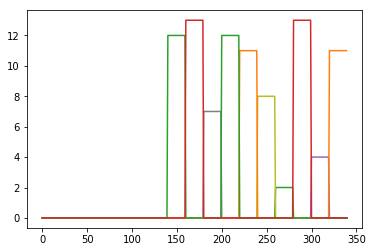

In [17]:
d_io = {}
#tableau des indices des phrases de data que l'on va utilisé
d_io['subset'] = [0]#range(15,41)

#temps d'activation
d_io['act_time'] = 20

#pause au debut et a la fin de la stimulation
d_io['suppl_pause_at_the_end'] = 0
d_io['initial_pause'] = True

#tableau des mots dans l_input et les phrases dans l_data
(d_io['l_input'], d_io['l_data']) = get_corpus()

#calcul du nombre de mots dans chaque phrase
d_io['l_nr_word'] = [None]*len(d_io['l_data'])
for i in range(len(d_io['l_data'])):
        d_io['l_nr_word'][i] = len(d_io['l_data'][i])
#nombre max de mots dans une phrase
d_io['mult'] = max(d_io['l_nr_word'])

#calcul du temps total de stimulation
tempsMaxPhrase = d_io['act_time']*d_io['mult']
tempsPauseInit = d_io['act_time']*(1*d_io['initial_pause'])
tempsPauseFin = d_io['suppl_pause_at_the_end']
d_io['full_time'] = tempsMaxPhrase + tempsPauseInit + tempsPauseFin

#si on ne precise pas les phrases a utilisé, on utilise l'ensemble du corpus
if d_io['subset'] is None:
        d_io['subset'] = range(len(d_io['l_data']))
        
#création de la matrice representant le signal d'entré
#taille = nombre de phrase * nombre de mots possible * temps total de stimulation
stim_data = len(d_io['subset'])*[np.zeros((len(d_io['l_input']), d_io['full_time']))]

#difference entre le nombre max de mots dans une phrase et les mots dans celle-ci
l_offset = [d_io['mult']-x for x in d_io['l_nr_word']]
d_io['l_offset'] = l_offset

#generation de la stimulation pour chaque phrase de subset
idx_stim = 0 
for i in d_io['subset']:
    stim_data[idx_stim] = make_one_stim(d_io,i)
    idx_stim = idx_stim + 1

#generation du graphe
graphe = copy.deepcopy(stim_data)
for i in range(len(graphe[0])):
    for j in range(len(graphe[0][0])):
        if(graphe[0][i][j]==1):
            graphe[0][i][j] = j
        

#print(stim_data[i][j][k])#stimulation du mot k au temps j dans la phrase i

plt.plot(graphe[0])
#plt.plot(stim_data[0])